In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import datetime
import sys
import random
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# data
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# ml
sys.path.append('..')
import decisiveml as dml

In [2]:
# Assume CL futures margin
margin = 5000

start_date = datetime.date(2016, 1, 1)
end_date = datetime.date(2018, 1, 1)

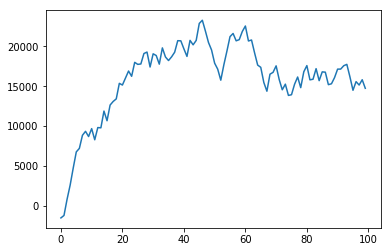

In [3]:
# We're going to generate a random list of trades,
# and you should replace this with your walkforward list of trades
trades_list = random.sample(range(-2000, 2300), 100)
cumsum = np.asarray(trades_list).cumsum()
plt.plot(cumsum)

In [4]:
# Initialize
mc = dml.MonteCarlo(trades_list)

# We will sample with replacement the number of trades per year
# so we need the start and end date to determine how many trades at in a year on average
mc.settings(margin, start_date, end_date)

# Test different levels of equity starting at this value
trial_starting_equity = int(margin * 1.5)

# Run the Monte Carlo
results = mc.run(trial_starting_equity)

In [5]:
# Put the results in a dataframe so it's nicer to look at in notebook
# Our goal is to get the highest equity below 10% Risk of Ruin
df = pd.DataFrame(index=range(1,len(results)))
count = 1
for result in results:
    df.loc[count, 'equity'] = result['equity']
    df.loc[count, 'is_ruined'] = result['is_ruined']
    df.loc[count, 'is_profitable'] = result['is_profitable']
    df.loc[count, 'returns_pct'] = result['returns_pct']
    df.loc[count, 'drawdown_pct'] = result['drawdown_pct']
    df.loc[count, 'returns_per_drawdown'] = result['returns_per_drawdown']
    count += 1

# Get the recommended values
recommended = df[df['is_ruined'] <= 10].iloc[0]
print('Recommend a starting equity of {}, which has {:0.2}% Risk-of-Ruin, \n\t{:0.0f}% Probability-of-Profit and a {:0.2f} Returns/Drawdown Ratio'.format(
                recommended['equity'], recommended['is_ruined'], 
                recommended['is_profitable'], recommended['returns_per_drawdown']))

if recommended['is_ruined'] > 10 or recommended['returns_per_drawdown'] < 2.0:
    print("Risk Assessment: FAILED")
else:
    print("Risk Assessment: PASSED")

mc_1p5x = recommended['drawdown_pct'] * 1.5
print("MC-Drawdown: {:0.1f}% MC-1.5x-DD: {:0.1f}%".format(recommended['drawdown_pct'], mc_1p5x))

profit = recommended['equity'] * recommended['returns_pct'] / 100
months = (end_date - start_date).days/30
average_monthly_net_profit = profit / months
print("Average monthly net profit: {:0.1f}".format(average_monthly_net_profit))

df

Recommend a starting equity of 15000.0, which has 5.9% Risk-of-Ruin, 
	81% Probability-of-Profit and a 1.65 Returns/Drawdown Ratio
Risk Assessment: FAILED
MC-Drawdown: 30.2% MC-1.5x-DD: 45.2%
Average monthly net profit: 307.8


,equity,is_ruined,is_profitable,returns_pct,drawdown_pct,returns_per_drawdown
1,7500.0,51.12,78.00,91.0,52.234895,1.684248
2,9375.0,31.56,78.52,73.0,44.166742,1.652892
3,11250.0,18.36,79.88,63.0,37.870330,1.668767
4,13125.0,11.44,79.64,54.0,33.437929,1.610903
5,15000.0,5.88,80.52,50.0,30.165863,1.654475
6,16875.0,3.56,79.24,43.0,27.685320,1.515129
7,18750.0,1.48,80.00,38.0,25.447673,1.495018
8,20625.0,0.96,80.32,34.0,23.389257,1.446991
9,22500.0,0.40,79.96,32.0,21.974094,1.450085
10,24375.0,0.16,80.48,29.0,20.620572,1.403772


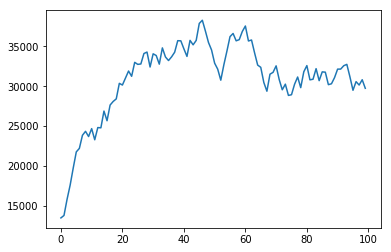

In [6]:
plt.plot(cumsum + recommended['equity'])